# 0. Importing Necessary Packages

In [1]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information

Software versions
Python 3.7.9 64bit [GCC 7.3.0]
IPython 7.16.1
OS Linux 5.8.18 100.fc31.x86_64 x86_64 with fedora 31 Thirty_One
Sat Apr 02 20:23:19 2022 KST

In [2]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'scipy', 'matplotlib', 'astropy', 'pandas', 'statsmodels']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.21.0
scipy: ver 1.6.2
matplotlib: ver 3.2.2
astropy: ver 4.2.1
pandas: ver 1.2.4
statsmodels: ver 0.12.2


In [3]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
from matplotlib import pyplot as plt

# 1. Reading the Data

In [4]:
# Observation data: r-band magnitude, r-band magnitude error, and airmass
obs = pd.read_csv("Calibration/Observation.csv")
obs.head(10)

,Star,r_obs,e_r_obs,airmass
0,1,10.484,0.143,1.199
1,2,11.641,0.182,1.199
2,3,9.215,0.074,1.199
3,4,9.047,0.033,1.199
4,5,9.502,0.036,1.199
5,6,10.025,0.344,1.199
6,7,9.079,0.054,1.199
7,8,9.914,0.046,1.199
8,9,13.015,0.239,1.331
9,10,13.206,0.286,1.331


In [5]:
# Standard star data: V-band magnitude, and color indices of B-V, U-B, V-R, R-I, and V-I
lan = pd.read_csv("Calibration/Landolt_catalog.csv")
lan.head(10)

,Star,V,B-V,U-B,V-R,R-I,V-I
0,1,13.004,1.040,0.737,0.607,0.681,1.287
1,2,14.196,1.052,0.380,0.606,0.597,1.203
2,3,11.737,0.987,0.639,0.600,0.674,1.273
3,4,12.330,2.326,2.326,1.373,1.250,2.625
4,5,11.773,0.671,0.506,0.373,0.436,0.808
5,6,14.022,1.248,1.323,0.797,0.683,1.482
6,7,11.312,0.568,0.059,0.335,0.312,0.652
7,8,12.440,1.141,0.830,0.633,0.579,1.206
8,9,14.767,-0.252,-1.091,-0.111,-0.182,-0.296
9,10,15.553,0.830,0.356,0.433,0.389,0.824


In [6]:
# Merging all the data in one data frame (for convenience)
df = pd.merge(lan, obs, how="left", on="Star")
df['R'] = -(df['V-R']-df['V'])
df.head(10)

,Star,V,B-V,U-B,V-R,R-I,V-I,r_obs,e_r_obs,airmass,R
0,1,13.004,1.040,0.737,0.607,0.681,1.287,10.484,0.143,1.199,12.397
1,2,14.196,1.052,0.380,0.606,0.597,1.203,11.641,0.182,1.199,13.590
2,3,11.737,0.987,0.639,0.600,0.674,1.273,9.215,0.074,1.199,11.137
3,4,12.330,2.326,2.326,1.373,1.250,2.625,9.047,0.033,1.199,10.957
4,5,11.773,0.671,0.506,0.373,0.436,0.808,9.502,0.036,1.199,11.400
5,6,14.022,1.248,1.323,0.797,0.683,1.482,10.025,0.344,1.199,13.225
6,7,11.312,0.568,0.059,0.335,0.312,0.652,9.079,0.054,1.199,10.977
7,8,12.440,1.141,0.830,0.633,0.579,1.206,9.914,0.046,1.199,11.807
8,9,14.767,-0.252,-1.091,-0.111,-0.182,-0.296,13.015,0.239,1.331,14.878
9,10,15.553,0.830,0.356,0.433,0.389,0.824,13.206,0.286,1.331,15.120


In [7]:
# Defining functions (for convenience)

# Plot - Observed values vs. Fitted values
def plot_comparison(input_data, fitted_data):
    arr0 = np.linspace(-5.0, 0.0, 1000)
    min_limit = np.minimum(input_data.min(), fitted_data.min()) - 0.2
    max_limit = np.maximum(input_data.max(), fitted_data.max()) + 0.2

    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(arr0, arr0, 'r--', linewidth=1.5, alpha=0.6)
    ax.plot(input_data, fitted_data, 'o', color='blue', ms=4.0)
    ax.tick_params(axis='both', labelsize=12.0)
    ax.set_xlabel(r"Observed $r-R$", fontsize=12.0)
    ax.set_ylabel(r"Fitted $r-R$", fontsize=12.0)
    ax.set_xlim([min_limit, max_limit])
    ax.set_ylim([min_limit, max_limit])
    plt.tight_layout()

# Plot - Observed values vs. Residuals
def plot_residuals(input_data, residuals):
    arr0 = np.linspace(-5.0, 0.0, 1000)
    min_limit = input_data.min() - 0.2
    max_limit = input_data.max() + 0.2
    RMSE = np.sqrt(np.sum(residuals**2) / len(input_data))

    fig, ax = plt.subplots(figsize=(5,5))
    ax.plot(arr0, np.zeros_like(arr0), 'r--', linewidth=1.5, alpha=0.6)
    ax.plot(input_data, residuals, 'o', color='blue', ms=4.0)
    ax.tick_params(axis='both', labelsize=12.0)
    ax.set_xlabel(r"Observed $r-R$", fontsize=12.0)
    ax.set_ylabel("Residuals", fontsize=12.0)
    ax.set_xlim([min_limit, max_limit])
    ax.set_ylim([-1.5, 1.5])
    ax.text(0.05, 0.95, f"RMS Error = {RMSE:.2f}", fontsize=13.0, fontweight='bold',
            transform=ax.transAxes, ha='left', va='top')
    plt.tight_layout()

# Printing the summary of model
def summary_model(x, y, e_y):
    Xm = sm.add_constant(x)
    model = sm.WLS(y.astype('float'), Xm.astype('float'), weights=1/e_y**2).fit() 
    print_model = model.summary()
    print(print_model)

# 2. Linear Regression

## 1) Multiple linear regression with all the data

$\large r-R = Zero(R) + k(R) \times airmass + c(R) \times (V-R)$

### **We have to guess the three parameters: $Zero(R)$, $k(R)$, and $c(R)$.**

* $Zero(R)$: Zeropoint (different from 25.0!)
* $k(R)$: Extinction coefficient
* $c(R)$: Color coefficient

In [8]:
# Setting X and Y for multiple linear regression
X = df[['airmass', 'V-R']]
Y = df['r_obs'] - df['R']
e_Y = df['e_r_obs']

In [9]:
# Running the multiple linear regression
regr = linear_model.LinearRegression()
regr.fit(X, Y)    # Without considering magnitude error
regr.fit(X, Y, 1/e_Y**2.)    # With considering magnitude error
print(f"Zeropoint: Zero(R) = {regr.intercept_:.3f}")
print("\nCoeffients")
print(f"Extinction coefficient: k(R) = {regr.coef_[0]:.3f}")
print(f"Color coefficient: c(V-R) = {regr.coef_[1]:.3f}")
print("\n")
summary_model(X, Y, e_Y)
fitted_Y = regr.predict(X)
resi = Y - regr.predict(X)

Zeropoint: Zero(R) = -2.159

Coeffients
Extinction coefficient: k(R) = 0.215
Color coefficient: c(V-R) = -0.009


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            WLS   Adj. R-squared:                 -0.094
Method:                 Least Squares   F-statistic:                    0.3566
Date:                Sat, 02 Apr 2022   Prob (F-statistic):              0.707
Time:                        20:23:20   Log-Likelihood:                 14.482
No. Observations:                  16   AIC:                            -22.96
Df Residuals:                      13   BIC:                            -20.65
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

/home/jlee/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


### **Fitting results**

* $\large r-R = (-2.159 \pm 0.397) + (0.215 \pm 0.319) \times airmass + (-0.009 \pm 0.036) \times (V-R)$

### **How much reliable are these results?**

<IPython.core.display.Javascript object>


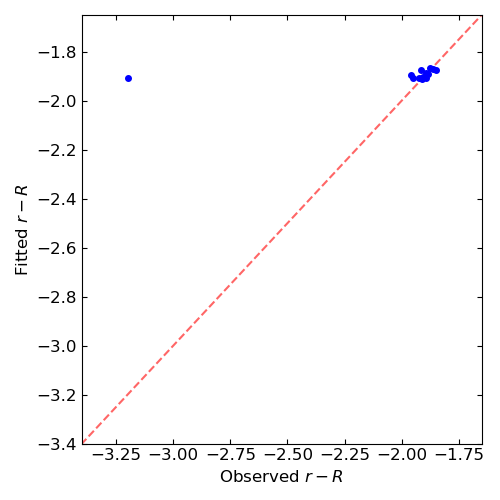

In [10]:
plot_comparison(Y, fitted_Y)    # Comparison plot (observed Y vs. fitted Y)

<IPython.core.display.Javascript object>


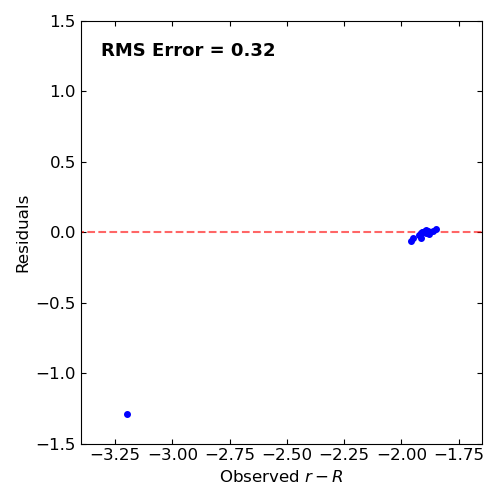

In [11]:
plot_residuals(Y, resi)

In [12]:
# Printing residuals
resi

0    -0.007138
1    -0.043147
2    -0.016199
3     0.002519
4     0.005828
5    -1.292487
6     0.005498
7     0.013088
8     0.008225
9    -0.038048
10    0.025353
11   -0.005350
12   -0.063622
13    0.006778
14    0.000124
15   -0.012245
dtype: float64

### **We should remove the data of Star 6 (index 5) for better results!**

## 2) Multiple linear regression with clipped data

In [13]:
df2 = df.drop(index = 5)    # Dropping the 5th index data (Star 6)
df2

,Star,V,B-V,U-B,V-R,R-I,V-I,r_obs,e_r_obs,airmass,R
0,1,13.004,1.040,0.737,0.607,0.681,1.287,10.484,0.143,1.199,12.397
1,2,14.196,1.052,0.380,0.606,0.597,1.203,11.641,0.182,1.199,13.590
2,3,11.737,0.987,0.639,0.600,0.674,1.273,9.215,0.074,1.199,11.137
3,4,12.330,2.326,2.326,1.373,1.250,2.625,9.047,0.033,1.199,10.957
4,5,11.773,0.671,0.506,0.373,0.436,0.808,9.502,0.036,1.199,11.400
6,7,11.312,0.568,0.059,0.335,0.312,0.652,9.079,0.054,1.199,10.977
7,8,12.440,1.141,0.830,0.633,0.579,1.206,9.914,0.046,1.199,11.807
8,9,14.767,-0.252,-1.091,-0.111,-0.182,-0.296,13.015,0.239,1.331,14.878
9,10,15.553,0.830,0.356,0.433,0.389,0.824,13.206,0.286,1.331,15.120
10,11,11.989,0.593,0.005,0.364,0.344,0.711,9.775,0.065,1.331,11.625


In [14]:
# Setting X and Y for multiple linear regression
X = df2[['airmass', 'V-R']]    # Multiple linear regression with clipped data
Y = df2['r_obs'] - df2['R']
e_Y = df2['e_r_obs']

In [15]:
# Running the multiple linear regression
regr = linear_model.LinearRegression()
regr.fit(X, Y, 1/e_Y**2.)
print(f"Zeropoint: Zero(R) = {regr.intercept_:.3f}")
print("\nCoeffients")
print(f"Extinction coefficient: k(R) = {regr.coef_[0]:.3f}")
print(f"Color term: c(V-R) = {regr.coef_[1]:.3f}")
print("\n")
summary_model(X, Y, e_Y)
fitted_Y = regr.predict(X)
resi = Y - regr.predict(X)

Zeropoint: Zero(R) = -2.141

Coeffients
Extinction coefficient: k(R) = 0.202
Color term: c(V-R) = -0.007


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.580
Model:                            WLS   Adj. R-squared:                  0.510
Method:                 Least Squares   F-statistic:                     8.275
Date:                Sat, 02 Apr 2022   Prob (F-statistic):            0.00551
Time:                        20:23:20   Log-Likelihood:                 39.961
No. Observations:                  15   AIC:                            -73.92
Df Residuals:                      12   BIC:                            -71.80
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

/home/jlee/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


### **Fitting results**

* $\large r-R = (-2.141 \pm 0.075) + (0.202 \pm 0.060) \times airmass + (-0.007 \pm 0.007) \times (V-R)$

<IPython.core.display.Javascript object>


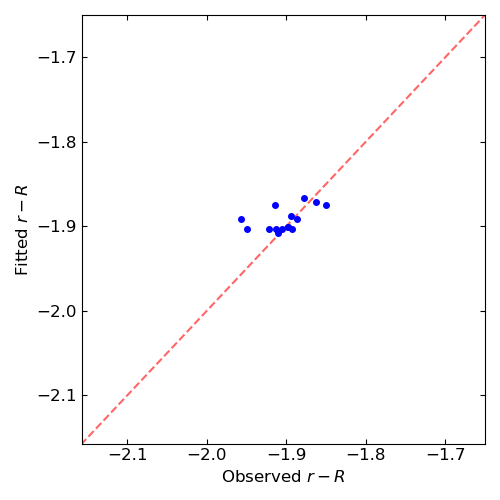

In [16]:
plot_comparison(Y, fitted_Y)

<IPython.core.display.Javascript object>


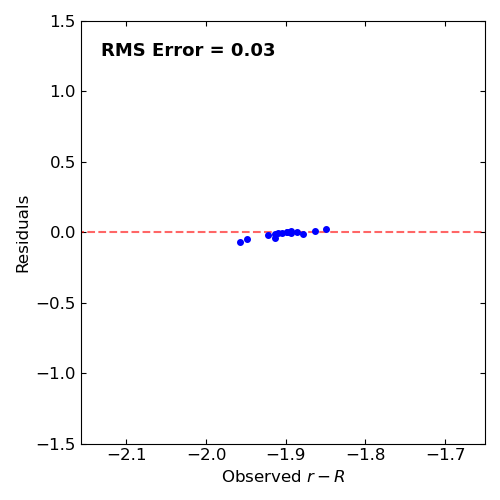

In [17]:
plot_residuals(Y, resi)

## 3) Adding the second-order term

### **Now we are going to add the second-order term as below.**

$\large r-R = Zero(R) + k(R) \times airmass + c(R) \times (V-R) + k_{2}(R) \times (V-R) \times airmass$

### **We have to guess the four parameters: $Zero(R)$, $k(R)$, $c(R)$, and $k_{2}(R)$.**

In [18]:
# Setting X and Y for multiple linear regression
df2['(V-R)X'] = df2['airmass']*df2['V-R']
X = df2[['airmass', 'V-R', '(V-R)X']]    # Multiple linear regression with the second-order term
Y = df2['r_obs'] - df2['R']
e_Y = df2['e_r_obs']

In [19]:
# Running the multiple linear regression
regr = linear_model.LinearRegression()
regr.fit(X, Y, 1/e_Y**2.)
print(f"Zeropoint: Zero(R) = {regr.intercept_:.3f}")
print("\nCoeffients")
print(f"Extinction coefficient: k(R) = {regr.coef_[0]:.3f}")
print(f"Color term: c(V-R) = {regr.coef_[1]:.3f}")
print(f"2nd-order term: k2(R) = {regr.coef_[2]:.3f}")
print("\n")
summary_model(X, Y, e_Y)
fitted_Y = regr.predict(X)
resi = Y - regr.predict(X)

Zeropoint: Zero(R) = -2.104

Coeffients
Extinction coefficient: k(R) = 0.172
Color term: c(V-R) = -0.574
2nd-order term: k2(R) = 0.472


                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.697
Model:                            WLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     8.442
Date:                Sat, 02 Apr 2022   Prob (F-statistic):            0.00341
Time:                        20:23:21   Log-Likelihood:                 42.420
No. Observations:                  15   AIC:                            -76.84
Df Residuals:                      11   BIC:                            -74.01
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0

/home/jlee/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


### **Fitting results**

* $\large r-R = (-2.104 \pm 0.069) + (0.172 \pm 0.055) \times airmass + (-0.574 \pm 0.275) \times (V-R) + (0.472 \pm 0.229) \times (V-R) \times airmass$

<IPython.core.display.Javascript object>


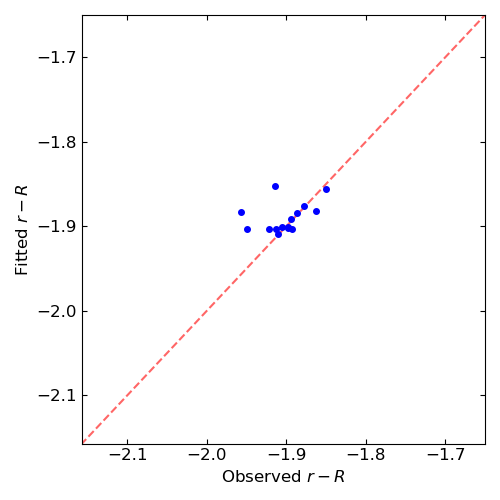

In [20]:
plot_comparison(Y, fitted_Y)

<IPython.core.display.Javascript object>


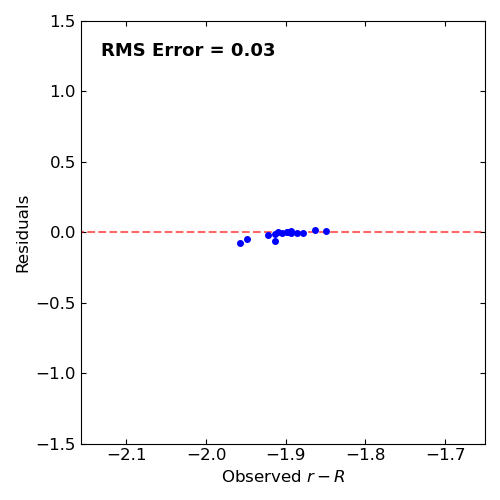

In [21]:
plot_residuals(Y, resi)

* We obtained the three linear regression (LR) models in this step. Theoretically, the LR model with the second-order term seems to be more reasonable than other models. However, **the second-order LR model is generally not used unless the observational data have very large sample and very precise measurement of magnitudes.** For the data of only 15 stars in this example, we had better select **the LR model without the second-order term**.

* $\large r-R = (-2.141 \pm 0.075) + (0.202 \pm 0.060) \times airmass + (-0.007 \pm 0.007) \times (V-R)$

# 3. Estimation of Standard Magnitudes

#### Applying the above model coefficients, we can estimate the standard magnitudes of an observed star.

$\large r-R = (-2.141 \pm 0.075) + (0.202 \pm 0.060) \times airmass + (-0.007 \pm 0.007) \times (V-R)$

#### Assuming that you obtained the following model for V-band magniude,

$\large v-V = (-2.504 \pm 0.085) + (0.237 \pm 0.153) \times airmass + (-0.010 \pm 0.005) \times (V-R)$ 

### **Q) When a star is observed $v=10.5\pm0.2~{\rm mag}$ and $r=10.0\pm0.1~{\rm mag}$ with airmass of $X=1.15~(v),~1.10~(r)$, what are the standard $V$ and $R$ magnitudes?**

#### In this case, we have to solve the above model equations for $V$ and $R$ with the obtained model coefficients and airmass.

In [22]:
from scipy.optimize import fsolve

#### We can numerically solve the following equations using ``scipy.optimize.fsolve`` for $V$ and $R$.

* $\large f_{1}(V,~R)=Zero(V) + k(V)\times airmass + c(V)\times(V-R)-(v-V) = 0$
* $\large f_{2}(V,~R)=Zero(R) + k(R)\times airmass + c(R)\times(V-R)-(r-R) = 0$

In [23]:
airmass = [1.15, 1.10]    # airmass
v_obs, r_obs = 10.5, 10.0    # observed magnitude v and r
e_v_obs, e_r_obs = 0.2, 0.1    # observed magnitude error of v and r

Zero_V, e_Zero_V, Zero_R, e_Zero_R = -2.504, 0.085, -2.141, 0.075    # zeropoints
k_V, e_k_V, k_R, e_k_R = 0.237, 0.153, 0.202, 0.060    # extinction coefficients
c_V, e_c_V, c_R, e_c_R = -0.010, 0.005, -0.007, 0.007    # color coefficients

In [24]:
def equations(var):
    V, R = var
    f1 = Zero_V + k_V*airmass[0] + c_V*(V-R) - (v_obs-V)
    f2 = Zero_R + k_R*airmass[1] + c_R*(V-R) - (r_obs-R)    
    return [f1, f2]

In [25]:
# initial guess (V0, R0) = (10.5, 10.0)
solution, infodict, ier, mesg = fsolve(equations, (9.5, 9.0), full_output=True)
print(f"V standard magnitude: {solution[0]:.3f}")
print(f"R standard magnitude: {solution[1]:.3f}")
VR_color = solution[0] - solution[1]
print(f"V-R standard color: {VR_color:.3f}")

V standard magnitude: 12.740
R standard magnitude: 11.925
V-R standard color: 0.815


#### Now we obtained the standard magnitudes of $V=12.740~{\rm mag}$ and $R=11.925~{\rm mag}$, then how can we compute their uncertainties?

#### For example, the uncertainty of $V$ magnitude $(\sigma_{V})$ can be propagated by the known uncertainties of $\sigma_{Zero(V)}$, $\sigma_{k(V)}$, $\sigma_{c(V)}$, and $\sigma_{v}$.

$\large \sigma_{V}^{2}=\left(\frac{\partial V}{\partial Zero(V)}\right)^{2}\times\sigma_{Zero(V)}^{2}+
\left(\frac{\partial V}{\partial k(V)}\right)^{2}\times\sigma_{k(V)}^{2}+
\left(\frac{\partial V}{\partial c(V)}\right)^{2}\times\sigma_{c(V)}^{2}+
\left(\frac{\partial V}{\partial v}\right)^{2}\times\sigma_{v}^{2}
$

#### Reference: [Uncertainty propagation](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) and [Using autograd for error propagation](https://kitchingroup.cheme.cmu.edu/blog/category/uncertainty/)

#### Taking derivatives of $f_{1}(V,~R)= 0$ (given above), we can get the derivative of each variable.

$\large \frac{\partial V}{\partial Zero(V)}=-\frac{1}{c(V)+1},$

$\large \frac{\partial V}{\partial k(V)}=-\frac{X}{c(V)+1},$

$\large \frac{\partial V}{\partial c(V)}=-(V-R),$

$\large \frac{\partial V}{\partial v}=\frac{1}{c(V)+1}$

In [26]:
VR_color = solution[0] - solution[1]
dVdZero = -1./(c_V+1)
dVdk = -airmass[0]/(c_V+1)
dVdc = -VR_color
dVdv = 1./(c_V+1)

V_err = np.sqrt((dVdZero * e_Zero_V)**2. + \
                (dVdk * e_k_V)**2. + \
                (dVdc * e_c_V)**2. + \
                (dVdv * e_v_obs)**2.)
print(f"V standard magnitude: {solution[0]:.3f} +/- {V_err:.3f}")

V standard magnitude: 12.740 +/- 0.282


#### Similarly, we can also compute the uncertainty of the standard $R$ magnitude. 

In [27]:
dRdZero = -1./(c_R+1)
dRdk = -airmass[1]/(c_R+1)
dRdc = -VR_color
dRdv = 1./(c_R+1)

R_err = np.sqrt((dRdZero * e_Zero_R)**2. + \
                (dRdk * e_k_R)**2. + \
                (dRdc * e_c_R)**2. + \
                (dRdv * e_r_obs)**2.)
print(f"R standard magnitude: {solution[1]:.3f} +/- {R_err:.3f}")

R standard magnitude: 11.925 +/- 0.142


#### If the above method is too tricky, then you can simply do the Gaussian random resampling as below.

In [28]:
# Gaussian random resampling
np.random.seed(123)
niter = 10000    # Iterations
sol = []
for i in np.arange(niter):
    v_obs2, r_obs2 = np.random.normal(v_obs, e_v_obs), np.random.normal(r_obs, e_r_obs)

    Zero_V2, Zero_R2 = np.random.normal(Zero_V, e_Zero_V), np.random.normal(Zero_R, e_Zero_R)
    k_V2, k_R2 = np.random.normal(k_V, e_k_V), np.random.normal(k_R, e_k_R)
    c_V2, c_R2 = np.random.normal(c_V, e_c_V), np.random.normal(c_R, e_c_R)
    
    def f(var):
        V, R = var
        f1 = Zero_V2 + k_V2*airmass[0] + c_V2*(V-R) - (v_obs2-V)
        f2 = Zero_R2 + k_R2*airmass[1] + c_R2*(V-R) - (r_obs2-R)    
        return [f1, f2]        
    
    sol_i, _, _, _ = fsolve(f, (10.5, 10.0), full_output=True)
    sol.append(sol_i)

V2, R2 = np.mean(np.array(sol), axis=0)
V2_err, R2_err = np.std(np.array(sol), axis=0)

print(f"V standard magnitude: {V2:.3f} +/- {V2_err:.3f}")
print(f"R standard magnitude: {R2:.3f} +/- {R2_err:.3f}")

V standard magnitude: 12.743 +/- 0.282
R standard magnitude: 11.924 +/- 0.140
